In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy.stats as s 
import gc
plt.rcParams['font.size'] = 13
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.linewidth'] = 1.5
%matplotlib inline

path = '../c_code/abc_data/'

# `py` ABC

In [2]:
from abc_sir import *

In [ ]:
# Set random seed for reproducibility.
np.random.seed(42)

ndays = 600
N = 1000

# Create a mock dataset using fiducial parameters.
fiducial_beta = 0.1
fiducial_gamma = 0.01
observed_S, observed_I, observed_R = simulator(fiducial_beta, fiducial_gamma, ndays, N)
observed_data = np.array([observed_S, observed_I, observed_R], ndmin=2)

# Initialize the ABC SIR object.
# To use fixed epsilon, set epsilon_fixed to a value.
# For 75th percentile rule, leave epsilon_fixed as None.
abc = ABCSIR(observed=observed_data, exponent_scale=0.1, beta_a=1e-2, beta_b=1,
                 simulator_func=simulator, distance_func=distance,
                 ndays=ndays, N=N, n_iterations=10_000, epsilon_fixed=20)
abc.run()

# Save results (the .npz file contains S, R, I, epsilon arrays)
# abc.save_results('/home/ubuntu/iti/data/abc_sir_results.npz')

# Plotting
plot_histograms(abc.accepted_betas, abc.accepted_gammas, fiducial_beta, fiducial_gamma)
# if abc.epsilon_fixed is None and len(abc.epsilon_history) > 0:
#     plot_epsilon_update(abc.epsilon_history)
# plot_trace(abc.accepted_betas, abc.accepted_gammas, fiducial_beta, fiducial_gamma)

In [ ]:
plt.plot(abc.accepted_betas, abc.accepted_gammas, 'o', alpha=0.1)

In [ ]:
plt.plot(observed_S, label='S', color='blue')
plt.plot(observed_I, label='I', color='red')
plt.plot(observed_R, label='R', color='green')
plt.legend()
plt.show()

# `py` SMC-ABC

In [2]:
from smc_abc_sir import *

In [ ]:
np.random.seed(42)
    
ndays = 600
N = 1000

# Create a mock dataset using fiducial parameters.
fiducial_beta = 0.1
fiducial_gamma = 0.01
observed_S, observed_I, observed_R = simulator(fiducial_beta, fiducial_gamma, ndays, N)
observed_data = np.array([observed_S, observed_I, observed_R], ndmin=2)

# Initialize and run the ABC SMC algorithm.
abc_smc = ABCSMC(observed=observed_data, exponent_scale=0.1, beta_a=1e-2, beta_b=1,
                    simulator_func=simulator, distance_func=distance,
                    ndays=ndays, N=N, n_generations=5, population_size=10_000)
abc_smc.run()

# Save results.
# abc_smc.save_results('/home/ubuntu/iti/project/abc_smc_results.npz')

# Plotting.
plot_histograms(abc_smc.accepted_betas, abc_smc.accepted_gammas, fiducial_beta, fiducial_gamma)
plot_trace(abc_smc.accepted_betas, abc_smc.accepted_gammas, fiducial_beta, fiducial_gamma)

In [ ]:
plt.plot(abc_smc.accepted_betas, abc_smc.accepted_gammas, 'o', alpha=0.1)
plt.plot(fiducial_beta, fiducial_gamma, 'o', color='red')

# `C` ABC

### Fiducial: $\beta=0.1$, $\gamma=0.01$

In [2]:
data_01 = pd.read_csv(path + 'abc_10k_01.csv')
data_02 = pd.read_csv(path + 'abc_10k_02.csv')
data_03 = pd.read_csv(path + 'abc_10k_03.csv')
data_05 = pd.read_csv(path + 'abc_10k_05.csv')
data_06 = pd.read_csv(path + 'abc_10k_06.csv')
data_10 = pd.read_csv(path + 'abc_10k_10.csv')
data_14 = pd.read_csv(path + 'abc_10k_14.csv')
data_16 = pd.read_csv(path + 'abc_10k_16.csv')
data_18 = pd.read_csv(path + 'abc_10k_18.csv')
data_20 = pd.read_csv(path + 'abc_10k_20.csv')

data_list = [data_01, data_02, data_03, data_05, data_06, data_10, data_14, data_16, data_18, data_20]

In [3]:
data_iter = pd.read_csv(path + 'abc_10k_iter.csv')

In [4]:
mean_betas = []
mean_gammas = []

median_betas = []
median_gammas = []

mode_betas = []
mode_gammas = []

for data in data_list:

    mean_betas.append(data['beta'].mean())
    mean_gammas.append(data['gamma'].mean())

    median_betas.append(data['beta'].median())
    median_gammas.append(data['gamma'].median())

    mode_betas.append(data['beta'].mode().values[0])
    mode_gammas.append(data['gamma'].mode().values[0])

mean_betas = np.array(mean_betas)
mean_gammas = np.array(mean_gammas)

median_betas = np.array(median_betas)
median_gammas = np.array(median_gammas)

mode_betas = np.array(mode_betas)
mode_gammas = np.array(mode_gammas)

In [ ]:
eps_list = [20, 18, 16, 14, 10, 6, 5, 3, 2, 1]
# x_ticks_pos = np.linspace(20, 0, len(eps_list))
x_ticks_pos = [20, 18, 16, 14, 10, 6, 5, 3, 2, 1]
fig, ax = plt.subplots(2,2, figsize=(18, 13))

ax[0,0].plot(eps_list, mean_betas, '-o', label='Mean')
ax[0,0].plot(eps_list, median_betas, '-x', label='Median')
ax[0,0].plot(eps_list, mode_betas, '-v', label='Mode')
ax[0,0].axhline(0.1, color='red', label=r'Fiducial $\beta$')
ax[0,0].set_xlabel(r'$\varepsilon$')
ax[0,0].set_ylabel(r'$\beta$')
ax[0,0].set_title(r'Inferred $\beta$ statistics')
ax[0,0].invert_xaxis()
ax[0,0].set_xticks(x_ticks_pos, eps_list)
ax[0,0].set_ylim(0.03, 0.18) #0.15
ax[0,0].legend()

ax[0,1].plot(eps_list, mean_gammas, '-o', label='Mean')
ax[0,1].plot(eps_list, median_gammas, '-x', label='Median')
ax[0,1].plot(eps_list, mode_gammas, '-v', label='Mode')
ax[0,1].axhline(0.01, color='red', label=r'Fiducial $\gamma$')
ax[0,1].set_xlabel(r'$\varepsilon$')
ax[0,1].set_ylabel(r'$\gamma$')
ax[0,1].set_title(r'Inferred $\gamma$ statistics')
ax[0,1].invert_xaxis()
ax[0,1].set_xticks(x_ticks_pos, eps_list)
ax[0,1].set_ylim(-0.002, 0.028) #0.030
ax[0,1].legend()

ax[1,0].plot(data_iter['eps'], data_iter['time'], '-o')
ax[1,0].set_xlabel(r'$\varepsilon$')
ax[1,0].set_ylabel(r'Time (s)') 
ax[1,0].set_title(r'Computation time')
ax[1,0].invert_xaxis()
ax[1,0].set_xticks(x_ticks_pos, eps_list)

ax[1,1].plot(data_iter['eps'], data_iter['avg_trial'], '-o')
ax[1,1].set_xlabel(r'$\varepsilon$')
ax[1,1].set_ylabel(r'Average trials')
ax[1,1].set_title(r'Average trials')
ax[1,1].invert_xaxis()
ax[1,1].set_xticks(x_ticks_pos, eps_list)

plt.show()

#### $\beta$ w/ residuals

In [ ]:
fig = plt.figure(figsize=(8,6))

frame1=fig.add_axes((.1,.3,.8,.6))
plt.plot(eps_list, mean_betas, '-o', label='Mean')
plt.plot(eps_list, median_betas, '-x', label='Median')
plt.plot(eps_list, mode_betas, '-v', label='Mode')
frame1.axhline(0.1, color='red', label=r'Fiducial $\beta$ = 0.1')
# ax.set_xlabel(r'$\varepsilon$')
plt.ylabel(r'$\beta$')
plt.title(r'Inferred $\beta$ statistics')
frame1.invert_xaxis()
frame1.set_xticks(x_ticks_pos, eps_list)
frame1.set_xticklabels([])
plt.ylim(0.03, 0.18)
plt.legend()


#Residual plot

frame2=fig.add_axes((.1,.1,.8,.2))  
plt.plot(eps_list, mean_betas-0.1, '-o', label='Mean')
plt.plot(eps_list, median_betas-0.1, '-x', label='Median')
plt.plot(eps_list, mode_betas-0.1, '-v', label='Mode')
frame2.axhline(0, linestyle='--', color='gray', alpha=0.7)
plt.xlabel(r'$\varepsilon$')
# plt.ylabel(r'$\beta$')
# plt._title(r'Inferred $\beta$ statistics')
frame2.invert_xaxis()
frame2.set_xticks(x_ticks_pos, eps_list)
plt.tight_layout()
plt.show()

#### $\gamma$ w/ residuals

In [ ]:
fig = plt.figure(figsize=(8,6))

frame1=fig.add_axes((.1,.3,.8,.6))
plt.plot(eps_list, mean_gammas, '-o', label='Mean')
plt.plot(eps_list, median_gammas, '-x', label='Median')
plt.plot(eps_list, mode_gammas, '-v', label='Mode')
frame1.axhline(0.01, color='red', label=r'Fiducial $\gamma$ = 0.01')
# ax.set_xlabel(r'$\varepsilon$')
plt.ylabel(r'$\beta$')
plt.title(r'Inferred $\gamma$ statistics')
frame1.invert_xaxis()
frame1.set_xticks(x_ticks_pos, eps_list)
frame1.set_xticklabels([])
plt.ylim(-0.002, 0.028)
plt.legend()


#Residual plot

frame2=fig.add_axes((.1,.1,.8,.2))  
plt.plot(eps_list, mean_gammas-0.01, '-o', label='Mean')
plt.plot(eps_list, median_gammas-0.01, '-x', label='Median')
plt.plot(eps_list, mode_gammas-0.01, '-v', label='Mode')
frame2.axhline(0, linestyle='--', color='gray', alpha=0.7)
# plt.ylabel(r'$\beta$')
# plt._title(r'Inferred $\beta$ statistics')
frame2.invert_xaxis()
frame2.set_xticks(x_ticks_pos, eps_list)
   
plt.show()

In [ ]:
fig, ax1 = plt.subplots(figsize=(8,6))

ax1.plot(data_iter['eps'], data_iter['time'], '--o', color='tab:red', 
         label='Computational time')
ax1.set_xlabel(r'$\varepsilon$')
ax1.set_ylabel(r'Time (s)', color='tab:red') 
ax1.invert_xaxis()
ax1.set_xticks(x_ticks_pos, eps_list)

ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis

ax2.plot(data_iter['eps'], data_iter['avg_trial'], '-o', color='tab:blue',
         label='Average trials', alpha=0.7)
ax2.set_xlabel(r'$\varepsilon$')
ax2.set_ylabel(r'Average trials', color='tab:blue')
# ax2.invert_xaxis()
ax2.set_xticks(x_ticks_pos, eps_list)


fig.tight_layout()  # otherwise the right y-label is slightly clipped

plt.show()

In [ ]:
plt.hist(data_c20['beta'], bins=20, alpha=0.5, color='blue', label='beta')
ymin, ymax = plt.ylim()
plt.vlines(0.1, ymin, ymax, color='blue', label='true beta')
plt.vlines(np.median(data_c20['beta']), ymin, ymax, color='blue', linestyle='dashed', label='median beta')
plt.legend()
plt.show()

In [ ]:
plt.hist(data_c['gamma'], bins=20, alpha=0.5, color='blue', label='gamma')
ymin, ymax = plt.ylim()
plt.vlines(0.01, ymin, ymax, color='blue', label='true gamma')
plt.vlines(np.median(data_c['gamma']), ymin, ymax, color='blue', linestyle='dashed', label='median gamma')
plt.legend()
plt.show()

In [ ]:
sns.jointplot(data_01_n, x='beta', y='gamma', color='blue', kind='hist')
plt.plot(0.2, 0.03, 'X', color='red')

### Fiducial: $\beta=0.2$, $\gamma=0.03$

In [16]:
data_01_n = pd.read_csv(path + 'abc_10k_02003_01.csv')
data_02_n = pd.read_csv(path + 'abc_10k_02003_02.csv')
data_03_n = pd.read_csv(path + 'abc_10k_02003_03.csv')
data_05_n = pd.read_csv(path + 'abc_10k_02003_05.csv')
data_06_n = pd.read_csv(path + 'abc_10k_02003_06.csv')
data_10_n = pd.read_csv(path + 'abc_10k_02003_10.csv')
data_14_n = pd.read_csv(path + 'abc_10k_02003_14.csv')
data_16_n = pd.read_csv(path + 'abc_10k_02003_16.csv')
data_18_n = pd.read_csv(path + 'abc_10k_02003_18.csv')
data_20_n = pd.read_csv(path + 'abc_10k_02003_20.csv')

data_list_n = [data_01_n, data_02_n, data_03_n, data_05_n, data_06_n, data_10_n,
                data_14_n, data_16_n, data_18_n, data_20_n]

In [17]:
data_iter_n = pd.read_csv(path + 'abc_10k_02003_iter.csv')

In [18]:
mean_betas_n = []
mean_gammas_n = []

median_betas_n = []
median_gammas_n = []

mode_betas_n = []
mode_gammas_n = []

for data in data_list_n:

    mean_betas_n.append(data['beta'].mean())
    mean_gammas_n.append(data['gamma'].mean())

    median_betas_n.append(data['beta'].median())
    median_gammas_n.append(data['gamma'].median())

    mode_betas_n.append(data['beta'].mode().values[0])
    mode_gammas_n.append(data['gamma'].mode().values[0])

mean_betas_n = np.array(mean_betas_n)
mean_gammas_n = np.array(mean_gammas_n)

median_betas_n = np.array(median_betas_n)
median_gammas_n = np.array(median_gammas_n)

mode_betas_n = np.array(mode_betas_n)
mode_gammas_n = np.array(mode_gammas_n)

In [ ]:
eps_list = [20, 18, 16, 14, 10, 6, 5, 3, 2, 1]
# x_ticks_pos = np.linspace(20, 0, len(eps_list))
x_ticks_pos = [20, 18, 16, 14, 10, 6, 5, 3, 2, 1]
fig, ax = plt.subplots(2,2, figsize=(18, 13))

ax[0,0].plot(eps_list, mean_betas_n, '-o', label='Mean')
ax[0,0].plot(eps_list, median_betas_n, '-x', label='Median')
ax[0,0].plot(eps_list, mode_betas_n, '-v', label='Mode')
ax[0,0].axhline(0.2, color='red', label=r'Fiducial $\beta$')
ax[0,0].set_xlabel(r'$\varepsilon$')
ax[0,0].set_ylabel(r'$\beta$')
ax[0,0].set_title(r'Inferred $\beta$ statistics')
ax[0,0].invert_xaxis()
ax[0,0].set_xticks(x_ticks_pos, eps_list)
# ax[0,0].set_ylim(0.1, 0.25)
ax[0,0].legend()

ax[0,1].plot(eps_list, mean_gammas_n, '-o', label='Mean')
ax[0,1].plot(eps_list, median_gammas_n, '-x', label='Median')
ax[0,1].plot(eps_list, mode_gammas_n, '-v', label='Mode')
ax[0,1].axhline(0.03, color='red', label=r'Fiducial $\gamma$')
ax[0,1].set_xlabel(r'$\varepsilon$')
ax[0,1].set_ylabel(r'$\gamma$')
ax[0,1].set_title(r'Inferred $\gamma$ statistics')
ax[0,1].invert_xaxis()
ax[0,1].set_xticks(x_ticks_pos, eps_list)
# ax[0,1].set_ylim(0.0065, 0.0##365)
ax[0,1].legend()

ax[1,0].plot(data_iter_n['eps'], data_iter_n['time'], '-o')
ax[1,0].set_xlabel(r'$\varepsilon$')
ax[1,0].set_ylabel(r'Time (s)') 
ax[1,0].set_title(r'Computation time')
ax[1,0].invert_xaxis()
ax[1,0].set_xticks(x_ticks_pos, eps_list)

ax[1,1].plot(data_iter_n['eps'], data_iter_n['avg_trial'], '-o')
ax[1,1].set_xlabel(r'$\varepsilon$')
ax[1,1].set_ylabel(r'Average trials')
ax[1,1].set_title(r'Average trials')
ax[1,1].invert_xaxis()
ax[1,1].set_xticks(x_ticks_pos, eps_list)

plt.show()

#### $\beta$ w/ residuals

In [ ]:
fig = plt.figure(figsize=(8,6))

frame1=fig.add_axes((.1,.3,.8,.6))
plt.plot(eps_list, mean_betas_n, '-o', label='Mean')
plt.plot(eps_list, median_betas_n, '-x', label='Median')
plt.plot(eps_list, mode_betas_n, '-v', label='Mode')
frame1.axhline(0.2, color='red', label=r'Fiducial $\beta$ = 0.2')
# ax.set_xlabel(r'$\varepsilon$')
plt.ylabel(r'$\beta$')
plt.title(r'Inferred $\beta$ statistics')
frame1.invert_xaxis()
frame1.set_xticks(x_ticks_pos, eps_list)
frame1.set_xticklabels([])
plt.legend()
# plt.grid(alpha=0.3)


#Residual plot

frame2=fig.add_axes((.1,.1,.8,.2))  
plt.plot(eps_list, mean_betas_n-0.2, '-o', label='Mean')
plt.plot(eps_list, median_betas_n-0.2, '-x', label='Median')
plt.plot(eps_list, mode_betas_n-0.2, '-v', label='Mode')
frame2.axhline(0, linestyle='--', color='gray', alpha=0.7)
plt.xlabel(r'$\varepsilon$')
# plt.ylabel(r'$\beta$')
# plt._title(r'Inferred $\beta$ statistics')
frame2.invert_xaxis()
frame2.set_xticks(x_ticks_pos, eps_list)
plt.tight_layout()
plt.grid(alpha=0.2)
plt.show()

#### $\gamma$ w/ residuals

In [ ]:
fig = plt.figure(figsize=(8,6))

frame1=fig.add_axes((.1,.3,.8,.6))
plt.plot(eps_list, mean_gammas_n, '-o', label='Mean')
plt.plot(eps_list, median_gammas_n, '-x', label='Median')
plt.plot(eps_list, mode_gammas_n, '-v', label='Mode')
frame1.axhline(0.03, color='red', label=r'Fiducial $\gamma$ = 0.03')
# ax.set_xlabel(r'$\varepsilon$')
plt.ylabel(r'$\beta$')
plt.title(r'Inferred $\gamma$ statistics')
frame1.invert_xaxis()
frame1.set_xticks(x_ticks_pos, eps_list)
frame1.set_xticklabels([])
# plt.ylim(-0.002, 0.028)
plt.legend()


#Residual plot

frame2=fig.add_axes((.1,.1,.8,.2))  
plt.plot(eps_list, mean_gammas_n-0.03, '-o', label='Mean')
plt.plot(eps_list, median_gammas_n-0.03, '-x', label='Median')
plt.plot(eps_list, mode_gammas_n-0.03, '-v', label='Mode')
frame2.axhline(0, linestyle='--', color='gray', alpha=0.7)
# plt.ylabel(r'$\beta$')
# plt._title(r'Inferred $\beta$ statistics')
frame2.invert_xaxis()
frame2.set_xticks(x_ticks_pos, eps_list)
plt.grid(alpha=0.2)
   
plt.show()

In [ ]:
fig, ax1 = plt.subplots(figsize=(8,6))

ax1.plot(data_iter_n['eps'], data_iter_n['time'], '--o', color='tab:red', 
         label='Computational time')
ax1.set_xlabel(r'$\varepsilon$')
ax1.set_ylabel(r'Time (s)', color='tab:red') 
ax1.invert_xaxis()
ax1.set_xticks(x_ticks_pos, eps_list)

ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis

ax2.plot(data_iter_n['eps'], data_iter_n['avg_trial'], '-o', color='tab:blue',
         label='Average trials')
ax2.set_xlabel(r'$\varepsilon$')
ax2.set_ylabel(r'Average trials', color='tab:blue')
# ax2.invert_xaxis()
ax2.set_xticks(x_ticks_pos, eps_list)


fig.tight_layout()  # otherwise the right y-label is slightly clipped

plt.show()

### Comparison

#### Median residual

In [ ]:
fig,ax = plt.subplots(2,1, figsize=(8,6))

ax[0].plot(eps_list, median_betas-0.1, '-o', label=r'$\beta$=0.1')
ax[0].plot(eps_list, median_betas_n-0.2, '--x', label=r'$\beta$=0.2')
ax[0].axhline(0, linestyle='--', color='gray', alpha=0.7)
ax[0].set_title(r'Residual Median $\beta$')
ax[0].set_xlabel(r'$\varepsilon$')
ax[0].set_xticks(x_ticks_pos, eps_list)
ax[0].invert_xaxis()
ax[0].legend(loc='center right')
ax[0].grid(alpha=0.2)

ax[1].plot(eps_list, median_gammas-0.01, '-o', label=r'$\gamma$=0.01')
ax[1].plot(eps_list, median_gammas_n-0.03, '--x', label=r'$\gamma$=0.03')
ax[1].axhline(0, linestyle='--', color='gray', alpha=0.7)
ax[1].set_title(r'Residual Median $\gamma$')
ax[1].set_xlabel(r'$\varepsilon$')
ax[1].set_xticks(x_ticks_pos, eps_list)
ax[1].invert_xaxis()
ax[1].legend(loc='center right')
ax[1].grid(alpha=0.2)

plt.tight_layout()

#### Computation time and avg trials

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))

ax[0].plot(data_iter['eps'], data_iter['time'], '--o', color='tab:red', 
         label=r'$\beta=0.1$, $\gamma=0.01$')
ax[0].plot(data_iter_n['eps'], data_iter_n['time'], '-o', color='tab:blue',
         label=r'$\beta=0.2$, $\gamma=0.03$')
ax[0].set_xlabel(r'$\varepsilon$')
ax[0].set_ylabel(r'Time (s)')
ax[0].set_title(r'Computation time')
ax[0].set_xticks(x_ticks_pos, eps_list)
ax[0].invert_xaxis()

ax[1].plot(data_iter['eps'], data_iter['avg_trial'], '--o', color='tab:red', 
         label=r'$\beta=0.1$, $\gamma=0.01$')
ax[1].plot(data_iter_n['eps'], data_iter_n['avg_trial'], '-o', color='tab:blue',
         label=r'$\beta=0.2$, $\gamma=0.03$')
ax[1].set_xlabel(r'$\varepsilon$')
ax[1].set_ylabel(r'Average trials')
ax[1].set_title(r'Avgerage trials')
ax[1].set_xticks(x_ticks_pos, eps_list)
ax[1].invert_xaxis()

fig.tight_layout()  # otherwise the right y-label is slightly clipped

plt.show()

#### Let's explore why the second fiducial are faster

We explore eps=5,3,2,1. eps=5 seems to be the last eps where the results are comparable

In [2]:
data_05_s = pd.read_csv(path + 'abc_10k_05_samples.csv')
data_03_s = pd.read_csv(path + 'abc_10k_03_samples.csv')
data_02_s = pd.read_csv(path + 'abc_10k_02_samples.csv')
data_01_s = pd.read_csv(path + 'abc_10k_01_samples.csv')

data_list_s = [data_05_s, data_03_s, data_02_s, data_01_s]

data_05_n_s = pd.read_csv(path + 'abc_10k_02003_05_samples.csv')
data_03_n_s = pd.read_csv(path + 'abc_10k_02003_03_samples.csv')
data_02_n_s = pd.read_csv(path + 'abc_10k_02003_02_samples.csv')
data_01_n_s = pd.read_csv(path + 'abc_10k_02003_01_samples.csv')

data_list_n_s = [data_05_n_s, data_03_n_s, data_02_n_s, data_01_n_s]

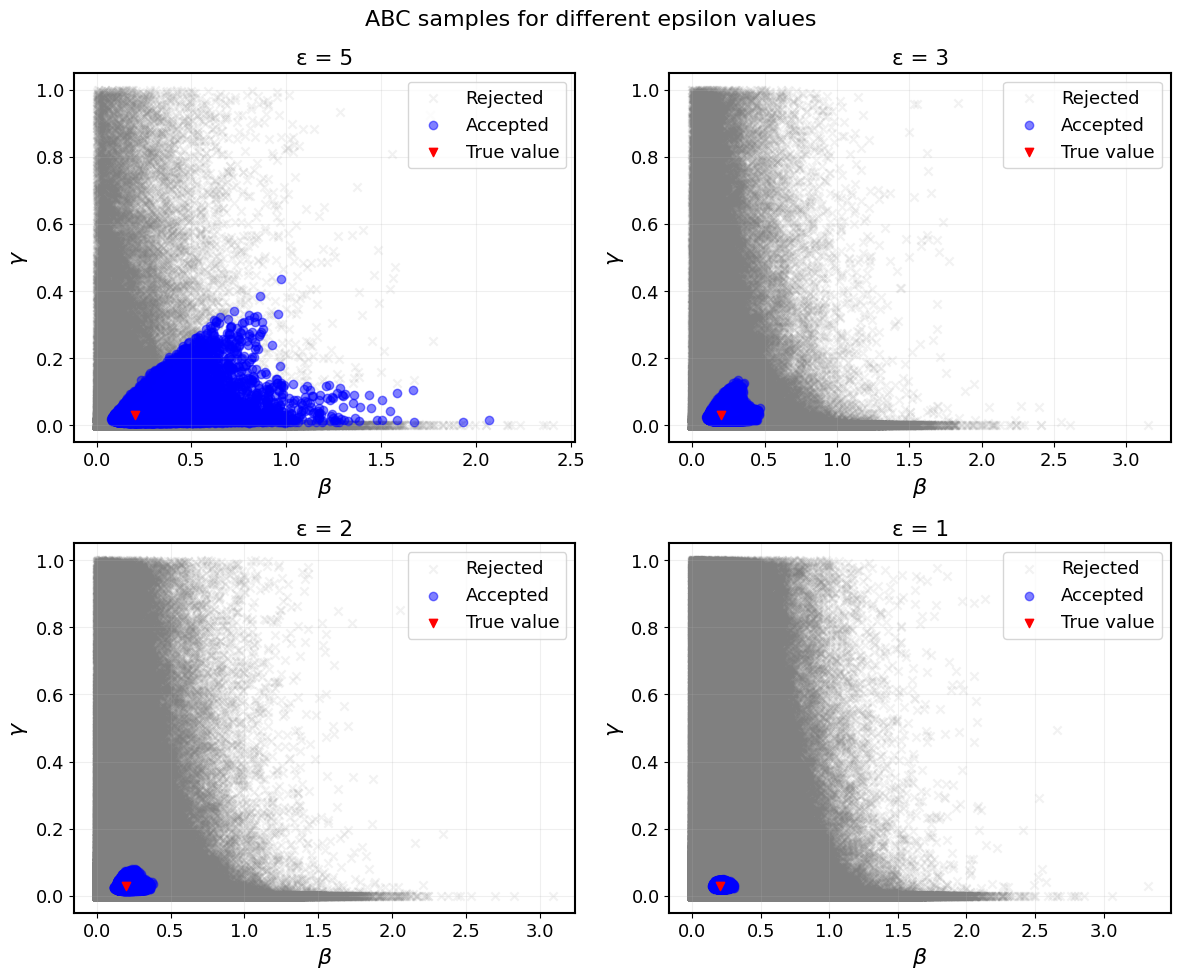

In [3]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('ABC samples for different epsilon values', fontsize=16)

# Epsilon = 1
axes[0,0].scatter(data_05_n_s[data_05_n_s['flag'] == 0]['beta'], 
                 data_05_n_s[data_05_n_s['flag'] == 0]['gamma'],
                 c='gray', marker='x', alpha=0.1, label='Rejected')
axes[0,0].scatter(data_05_n_s[data_05_n_s['flag'] == 1]['beta'], 
                 data_05_n_s[data_05_n_s['flag'] == 1]['gamma'],
                 c='blue', marker='o', alpha=0.5, label='Accepted')
axes[0,0].scatter(0.2, 0.03, color='red', marker='v', label='True value')
axes[0,0].set_title('ε = 5')

# Epsilon = 2
axes[0,1].scatter(data_03_n_s[data_03_n_s['flag'] == 0]['beta'], 
                 data_03_n_s[data_03_n_s['flag'] == 0]['gamma'],
                 c='gray', marker='x', alpha=0.1, label='Rejected')
axes[0,1].scatter(data_03_n_s[data_03_n_s['flag'] == 1]['beta'], 
                 data_03_n_s[data_03_n_s['flag'] == 1]['gamma'],
                 c='blue', marker='o', alpha=0.5, label='Accepted')
axes[0,1].scatter(0.2, 0.03, color='red', marker='v', label='True value')
axes[0,1].set_title('ε = 3')

# Epsilon = 3
axes[1,0].scatter(data_02_n_s[data_02_n_s['flag'] == 0]['beta'], 
                 data_02_n_s[data_02_n_s['flag'] == 0]['gamma'],
                 c='gray', marker='x', alpha=0.1, label='Rejected')
axes[1,0].scatter(data_02_n_s[data_02_n_s['flag'] == 1]['beta'], 
                 data_02_n_s[data_02_n_s['flag'] == 1]['gamma'],
                 c='blue', marker='o', alpha=0.5, label='Accepted')
axes[1,0].scatter(0.2, 0.03, color='red', marker='v', label='True value')
axes[1,0].set_title('ε = 2')

# Epsilon = 5
axes[1,1].scatter(data_01_n_s[data_01_n_s['flag'] == 0]['beta'], 
                 data_01_n_s[data_01_n_s['flag'] == 0]['gamma'],
                 c='gray', marker='x', alpha=0.1, label='Rejected')
axes[1,1].scatter(data_01_n_s[data_01_n_s['flag'] == 1]['beta'], 
                 data_01_n_s[data_01_n_s['flag'] == 1]['gamma'],
                 c='blue', marker='o', alpha=0.5, label='Accepted')
axes[1,1].scatter(0.2, 0.03, color='red', marker='v', label='True value')
axes[1,1].set_title('ε = 1')

# Set labels and grid for all subplots
for ax in axes.flat:
    ax.set(xlabel=r'$\beta$', ylabel=r'$\gamma$')
    ax.grid(alpha=0.2)
    ax.legend(loc='upper right')

plt.tight_layout()
plt.show()

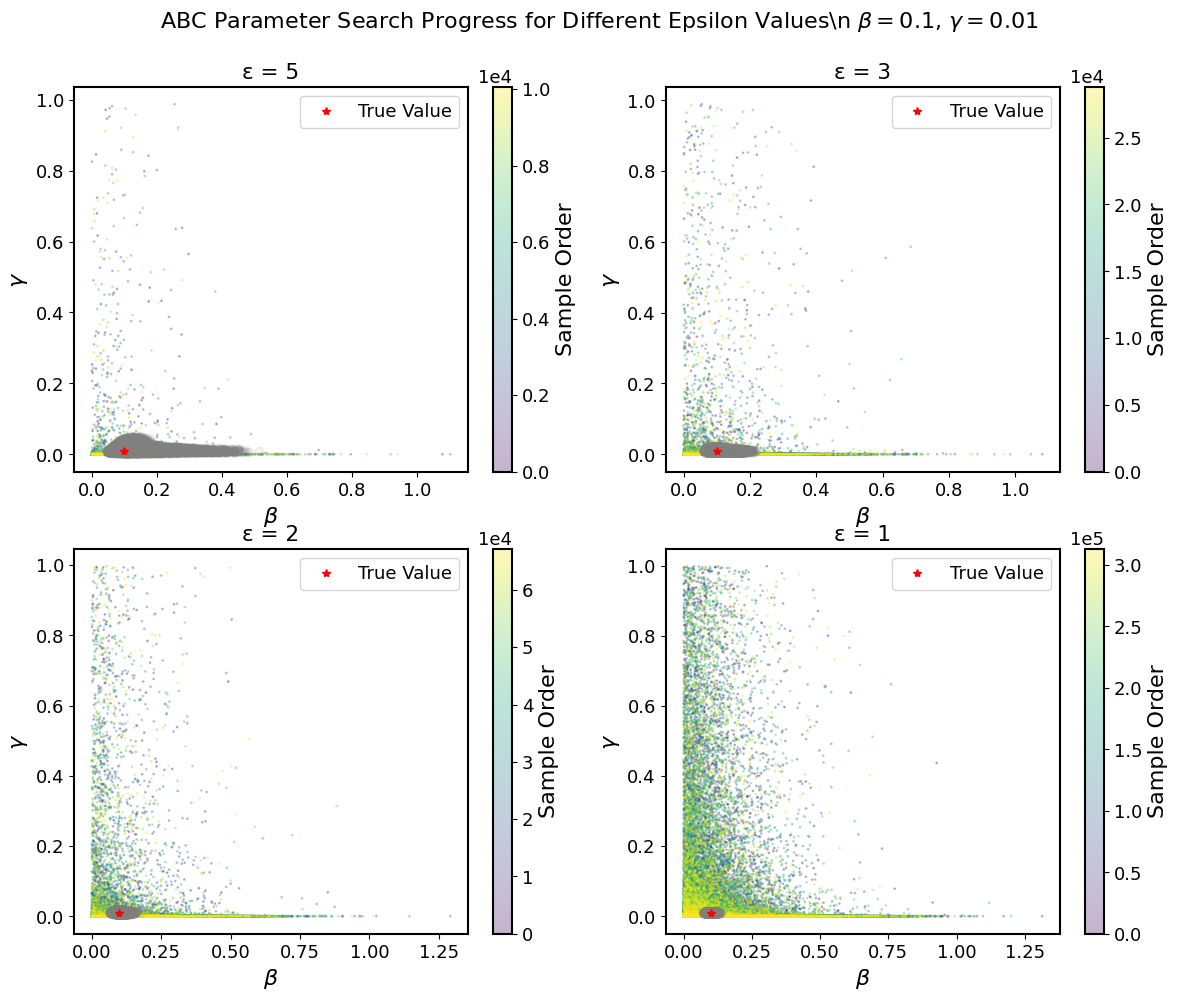

In [4]:
fig, axes = plt.subplots(2, 2, figsize=(14, 11))
fig.suptitle(r'ABC Parameter Search Progress for Different Epsilon Values\n $\beta=0.1$, $\gamma=0.01$', fontsize=16, y=0.95)

# Define datasets and their corresponding epsilon values
eps_values = [5, 3, 2, 1]

for idx, (ax, data, eps) in enumerate(zip(axes.flat, data_list_s, eps_values)):
    # Create scatter plot with color based on sample order
    scatter1 = ax.scatter(data['beta'][::100], data['gamma'][::100], 
                        c=np.arange(len(data[::100])), 
                        cmap='viridis',
                        alpha=0.3,
                        s=1)
    scatter2 = ax.scatter(data[data['flag'] == 1]['beta'], 
                        data[data['flag'] == 1]['gamma'],
                        c='gray', marker='o', alpha=0.1)
    
    # Plot true value
    ax.plot(0.1, 0.01, 'r*', label='True Value')
    
    # Add colorbar
    cbar = plt.colorbar(scatter1, ax=ax, label='Sample Order')
    cbar.formatter.set_powerlimits((0, 0))
    
    # Set labels and title
    ax.set_xlabel(r'$\beta$')
    ax.set_ylabel(r'$\gamma$')
    ax.set_title(f'ε = {eps}')
    
    # Add legend
    ax.legend(loc='upper right')

# plt.tight_layout()
plt.show()

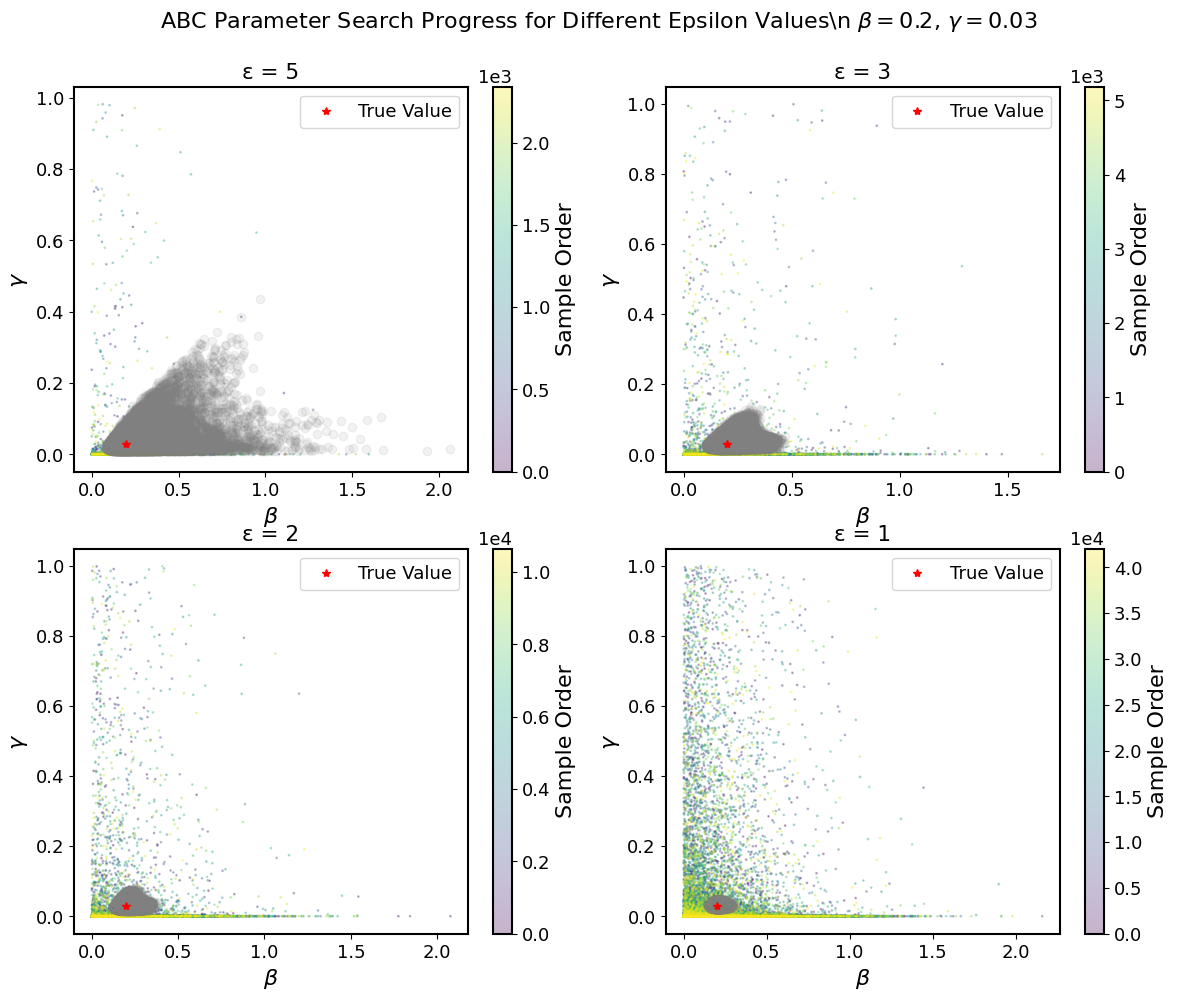

In [5]:
fig, axes = plt.subplots(2, 2, figsize=(14, 11))
fig.suptitle(r'ABC Parameter Search Progress for Different Epsilon Values\n $\beta=0.2$, $\gamma=0.03$', fontsize=16, y=0.95)

eps_values = [5, 3, 2, 1]

for idx, (ax, data, eps) in enumerate(zip(axes.flat, data_list_n_s, eps_values)):
    # Create scatter plot with color based on sample order
    scatter1 = ax.scatter(data['beta'][::100], data['gamma'][::100], 
                        c=np.arange(len(data[::100])), 
                        cmap='viridis',
                        alpha=0.3,
                        s=1)
    scatter2 = ax.scatter(data[data['flag'] == 1]['beta'], 
                        data[data['flag'] == 1]['gamma'],
                        c='gray', marker='o', alpha=0.1)
    
    # Plot true value
    ax.plot(0.2, 0.03, 'r*', label='True Value')
    
    # Add colorbar
    cbar = plt.colorbar(scatter1, ax=ax, label='Sample Order')
    cbar.formatter.set_powerlimits((0, 0))
    
    # Set labels and title
    ax.set_xlabel(r'$\beta$')
    ax.set_ylabel(r'$\gamma$')
    ax.set_title(f'ε = {eps}')
    
    # Add legend
    ax.legend(loc='upper right')

# plt.tight_layout()
plt.show()

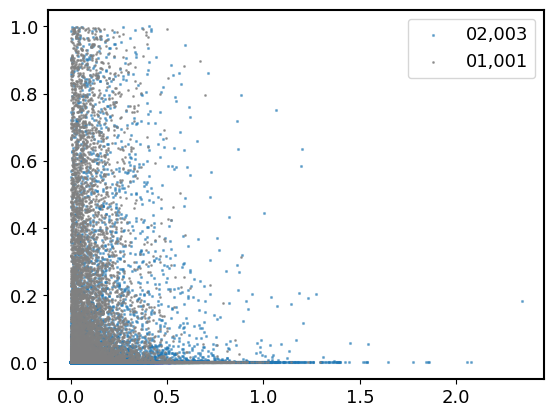

In [7]:
plt.scatter(data_02_n_s['beta'][::50], data_02_n_s['gamma'][::50], 
                        c='tab:blue',
                        alpha=0.5,
                        s=1.5, marker='X', label='02,003')
plt.scatter(data_02_s['beta'][::50], 
                        data_02_s['gamma'][::50],
                        c='gray', marker='o', alpha=0.7, s=1, zorder=100, label='01,001')
plt.legend(loc='upper right')
plt.show()

# plt.plot(0.2, 0.03, 'r*', label='True Value')

# `C` ABC-SMC

In [3]:
data_cc = pd.read_csv('/home/ubuntu/iti/project/C/abc_smc.csv')

In [ ]:
plt.plot(data_cc['beta'], data_cc['gamma'], 'o', alpha=0.3, label='ABC-SMC', zorder=100)
plt.plot(data_c['beta'], data_c['gamma'], 'o', alpha=0.1, label='ABC')
plt.plot(0.1, 0.01, 'o', color='red', zorder=100)
plt.legend()

In [ ]:
plt.hist(data_cc['beta'], bins=20, alpha=0.5, color='blue', label='beta')
ymin, ymax = plt.ylim()
plt.vlines(0.1, ymin, ymax, color='blue', label='true beta')
plt.vlines(np.median(data_cc['beta']), ymin, ymax, color='blue', linestyle='dashed', label='median beta')
plt.legend()
plt.show()

In [ ]:
plt.hist(data_cc['gamma'], bins=20, alpha=0.5, color='blue', label='gamma')
ymin, ymax = plt.ylim()
plt.vlines(0.01, ymin, ymax, color='blue', label='true gamma')
plt.vlines(np.median(data_cc['gamma']), ymin, ymax, color='blue', linestyle='dashed', label='median gamma')
plt.legend()
plt.show()

In [ ]:
plt.hist2d(data_cc['beta'], data_cc['gamma'], bins=int(np.sqrt(len(data_cc['beta']))), cmap='Blues')
plt.plot(0.1, 0.01, 'o', color='red')
plt.show()

In [32]:
path = "/home/ubuntu/iti/project/C/smc_data/"

gen_1 = pd.read_csv(path + '/abc_smc_gen_1.csv')
gen_2 = pd.read_csv(path + '/abc_smc_gen_2.csv')
gen_3 = pd.read_csv(path + '/abc_smc_gen_3.csv')
gen_4 = pd.read_csv(path + '/abc_smc_gen_4.csv')
gen_5 = pd.read_csv(path + '/abc_smc_gen_5.csv')
gen_6 = pd.read_csv(path + '/abc_smc_gen_6.csv')
gen_7 = pd.read_csv(path + '/abc_smc_gen_7.csv')
gen_8 = pd.read_csv(path + '/abc_smc_gen_8.csv')
gen_9 = pd.read_csv(path + '/abc_smc_gen_9.csv')
gen_10 = pd.read_csv(path + '/abc_smc_gen_10.csv')

In [ ]:
import scipy.stats as st

gens = [gen_1, gen_2, gen_3, gen_4, gen_5, gen_6, gen_7, gen_8, gen_9, gen_10]
colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']

fig, ax = plt.subplots(figsize=(8, 6))

for i, gen in enumerate(gens):
    beta = gen['beta'].values
    gamma = gen['gamma'].values
    plt.scatter(beta, gamma, marker='.', color=colors[i], alpha=0.1)

plt.plot(0.1, 0.01, 'X', color='black', label='True Parameters')
ax.set_xlabel('beta')
ax.set_ylabel('gamma')
ax.set_title('Contour Plot for All gen_* DataFrames')
ax.set_xlim(-0.01, 0.6)
ax.set_ylim(-0.01, 0.2)
plt.show()

In [ ]:
plt.scatter(gen_8['beta'], gen_8['gamma'], marker='.', color='blue', alpha=0.1)
plt.plot(0.1, 0.01, 'X', color='black', label='True Parameters')
plt.plot(np.median(gen_10['beta']), np.median(gen_10['gamma']), 'X', color='red', label='Median Parameters')
ax.set_xlabel('beta')
ax.set_ylabel('gamma')
ax.set_title('Contour Plot for All gen_* DataFrames')
plt.xlim(-0.01, 0.6)
plt.ylim(-0.01, 0.2)

In [ ]:
# for i, gen in enumerate(gens):
sns.jointplot(x='beta', y='gamma', data=gens[0], kind='kde', color=colors[0], fill=True)
plt.scatter(gens[0]['beta'], gens[0]['gamma'], marker='.', color='tab:red', alpha=0.1)
plt.xlim(-0.01, 0.6)
plt.ylim(-0.01, 0.2)

In [ ]:
df = gens[0][['beta', 'gamma']]
g = sns.PairGrid(gens[0], diag_sharey=False)
g.map_upper(sns.scatterplot, s=10, alpha=0.1)
g.map_lower(sns.kdeplot)
g.map_diag(sns.histplot, bins=100, kde=True)
# plt.xlim(-0.01, 0.6)
# plt.ylim(-0.01, 0.2)

In [ ]:
# Create a contour plot of the 2D distribution
for i, gen in enumerate(gens):
    sns.kdeplot(data=gen, x='beta', y='gamma', levels=[0.05], 
                color=colors[i], label=f'Generation {i+1}')
plt.legend()

plt.plot(0.1, 0.01, 'X', color='black', label='True Parameters', markersize=10)
plt.xlabel('beta')
plt.ylabel('gamma')
plt.title('Contour Outlines of Parameter Distributions')
plt.xlim(-0.01, 0.6)
plt.ylim(-0.01, 0.2)
plt.legend()
plt.show()

In [ ]:
gens = [gen_2, gen_3, gen_4, gen_5, gen_6, gen_7, gen_8, gen_9, gen_10]

for i, gen in enumerate(gens):
    sns.histplot(data=gen, x='beta', bins=50,
                color=colors[i], label=f'Generation {i+1}', alpha=0.3)
    plt.vlines(np.median(gen['beta']), 0, 2000, color=colors[i], linestyle='dashed')
plt.vlines(0.1, 0, 2000, color='yellow', label='True beta')

In [50]:
import matplotlib.animation as animation

# Create the figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

def update(frame):
    ax.clear()
    gen = gens[frame]
    
    # Plot histogram
    sns.histplot(data=gen, x='beta', bins=50, ax=ax, color='mediumseagreen')
    
    # Add vertical lines for true value and median
    ax.axvline(x=0.1, color='red', linestyle='solid', label='True Beta')
    ax.axvline(x=np.median(gen['beta']), color='black', linestyle='dashed', label='Median')
    
    # Set title and labels
    ax.set_title(f'Generation {frame + 1}')
    ax.set_xlabel('Beta')
    ax.set_ylabel('Count')
    ax.legend()
    
    # Set consistent x and y limits
    ax.set_xlim(0, 0.4)
    ax.set_ylim(0, 1750)

# Create the animation
anim = animation.FuncAnimation(fig, update, frames=len(gens), 
                               repeat=True, interval=3000)

# Save as GIF
anim.save(path+'beta_evolution.gif', writer='pillow')
plt.close()

In [71]:
import matplotlib.animation as animation
# Create the figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

def update(frame):
    ax.clear()
    gen = gens[frame]
    
    # Plot histogram
    ax.hist(gen['gamma'], color='mediumseagreen', density=False, edgecolor='black')
    
    # Add vertical lines for true value and median
    ax.axvline(x=0.01, color='red', linestyle='solid', label='True Beta')
    ax.axvline(x=np.median(gen['gamma']), color='black', linestyle='dashed', label='Median')
    
    # Set title and labels
    ax.set_title(f'Generation {frame + 1}')
    ax.set_xlabel('Gamma')
    ax.set_ylabel('Count')
    ax.legend()
    
    # Set consistent x and y limits
    ax.set_xlim(-0.01, 0.2)
    # ax.set_ylim(0, 4000)

# Create the animation
anim = animation.FuncAnimation(fig, update, frames=len(gens), 
                               repeat=True, interval=3000)

# Save as GIF
anim.save(path+'gamma_evolution.gif', writer='pillow')
plt.close()

In [ ]:
# Create histogram of gen_1's beta values
plt.hist(gen_5['beta'], bins=50, color='blue', alpha=0.5, density=True)

# Find the mode of the distribution (maximum point of KDE)
kde = st.gaussian_kde(gen_5['beta'])
x_range = np.linspace(gen_5['beta'].min(), gen_5['beta'].max(), 1000)
mode_x = x_range[np.argmax(kde(x_range))]

# Plot vertical lines
plt.axvline(x=0.1, color='red', linestyle='solid', label='True Beta')
plt.axvline(x=mode_x, color='green', linestyle='dashed', label=f'Mode: {mode_x:.3f}')
plt.axvline(x=np.median(gen_5['beta']), color='black', linestyle='dashed', label=f'Median: {np.median(gen_5["beta"]):.3f}')

plt.xlabel('Beta')
plt.ylabel('Density')
plt.title('Generation 1 Beta Distribution')
plt.legend()
plt.show()

In [75]:
fig, ax = plt.subplots(figsize=(10, 6))

def update(frame):
    ax.clear()
    gen = gens[frame]
    
    ax.hist(gen['beta'], bins=50, color='blue', alpha=0.5, density=True)

    # Find the mode of the distribution (maximum point of KDE)
    kde = st.gaussian_kde(gen['beta'])
    x_range = np.linspace(gen['beta'].min(), gen['beta'].max(), 1000)
    mode_x = x_range[np.argmax(kde(x_range))]

    # Plot vertical lines
    plt.axvline(x=0.1, color='red', linestyle='solid', label='True Beta')
    plt.axvline(x=mode_x, color='green', linestyle='dashed', label=f'Mode: {mode_x:.3f}')
    plt.axvline(x=np.median(gen['beta']), color='black', linestyle='dashed', label=f'Median: {np.median(gen["beta"]):.3f}')

    plt.xlabel('Beta')
    plt.ylabel('Density')
    plt.title(f'Generation {frame + 1}')
    plt.legend()

# Create the animation
anim = animation.FuncAnimation(fig, update, frames=len(gens), 
                               repeat=True, interval=3000)

# Save as GIF
anim.save(path+'beta_evolution.gif', writer='pillow')
plt.close()